In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import xgboost
import shap
import pandas as pd
import seaborn as sns
import matplotlib as mpl

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, r2_score
shap.initjs()
import hvplot.pandas

print(mpl.__version__)

3.5.2


# Adult Census Income

### Data Set Information:

Extraction was done by Barry Becker from the 1994 Census database. A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))

Prediction task is to determine whether a person makes over 50K a year.


### Attribute Information:

**Listing of attributes:**

target: >50K, <=50K.

inputs:
- age: continuous.
- workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- fnlwgt: continuous.
- education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- education-num: continuous.
- marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- sex: Female, Male.
- capital-gain: continuous.
- capital-loss: continuous.
- hours-per-week: continuous.
- native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

In [29]:
# https://archive.ics.uci.edu/ml/datasets/adult

seed = 7
X_display, y_display = shap.datasets.adult(display=True)
X, y = shap.datasets.adult(display=False)
# Fixing some types
y = y.astype(np.uint8)
y_display = y_display.astype(np.uint8)

xgb_full = xgboost.DMatrix(X, label=y)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

params = {
    'eta': 0.02,
    'max_depth': 3,
    'objective': 'binary:logistic',
    'subsample': 0.5,
    'seed': seed
}
model = xgboost.train(params, xgb_train, 5000, evals=[(xgb_test, "test")], verbose_eval=1000)

[0]	test-logloss:0.68230
[1000]	test-logloss:0.28195
[2000]	test-logloss:0.27875
[3000]	test-logloss:0.27846
[4000]	test-logloss:0.27930
[4999]	test-logloss:0.28015


In [48]:
y_pred = (model.predict(xgb_test) >= 0.5).astype(np.uint8)
print(f'# of train data: {xgb_train.num_row()}')
print(f'# of test data: {xgb_test.num_row()}')
print('Classification Report:')
print(classification_report(y_true=y_test, y_pred=y_pred))

# of train data: 26048
# of test data: 6513
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      4951
           1       0.78      0.66      0.71      1562

    accuracy                           0.87      6513
   macro avg       0.84      0.80      0.82      6513
weighted avg       0.87      0.87      0.87      6513



In [5]:
idx = np.arange(len(y_test))
sample_idx = np.concatenate((idx[y_test == 0][:5], idx[y_test == 1][:5]))
explainer = shap.TreeExplainer(model, data=X_test)
shap_values = explainer.shap_values(X_test.iloc[sample_idx, :])

In [7]:
i = sample_idx[0]
shap.force_plot(explainer.expected_value, shap_values[i], X_display.iloc[i, :])

In [8]:
i = sample_idx[6]
shap.force_plot(explainer.expected_value, shap_values[i], X_display.iloc[i, :])

calculate all shap values + shape interaction values

In [9]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)
shap_interaction_values = explainer.shap_interaction_values(X_test)

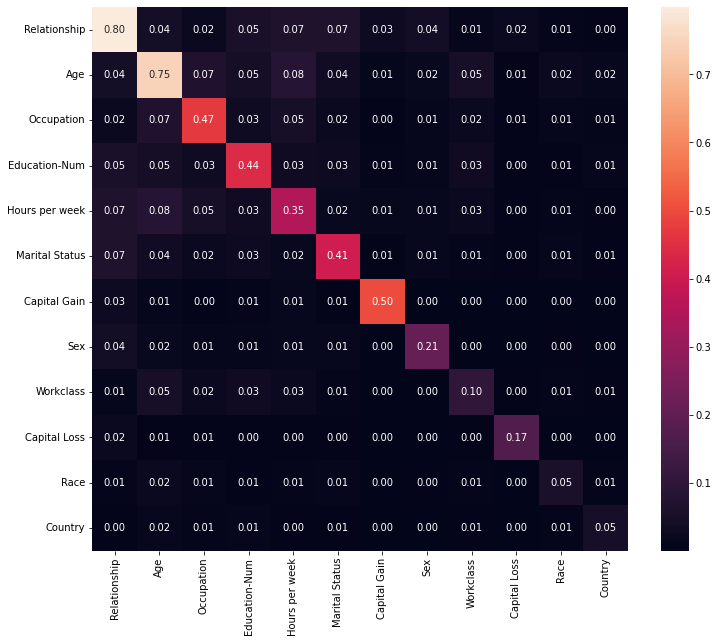

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

siv = shap_interaction_values.copy()
# due to calcuate absolute value, it can only measure the magnitude not the directions
tmp = np.abs(siv).mean(0)
inds = np.argsort(-tmp.mean(0))[:50]
tmp2 = tmp[inds,:][:,inds]
sns.heatmap(data=pd.DataFrame(tmp2, index=X_test.columns[inds], columns=X_test.columns[inds]), annot=True, fmt='.2f', ax=ax)
plt.show()

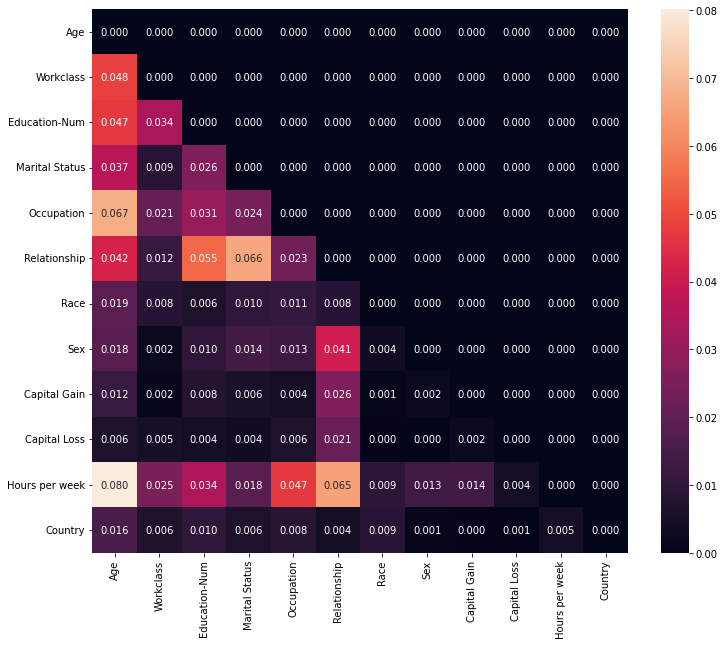

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

siv = shap_interaction_values.copy()

for i in range(len(siv)):
    r, c = np.triu_indices(12)
    siv[i, r, c] = 0.0

# due to calcuate absolute value, it can only measure the magnitude not the directions
tmp = np.abs(siv).mean(0)
sns.heatmap(data=pd.DataFrame(tmp, index=X_test.columns, columns=X_test.columns), annot=True, fmt='.3f', ax=ax)
plt.show()

In [59]:
# check shap_values are equal to main effect + interaction effect
print(shap_values.shape, shap_interaction_values.shape)
N, M = shap_values.shape

siv = shap_interaction_values.copy()
r_diag, c_diag = np.diag_indices(M)
for i in range(N):
    siv[i, r_diag, c_diag] = 0.0

print('SHAP values - (main effect + interaction effect) = ', end='')
print((shap_values.values - (shap_interaction_values[:, r_diag, c_diag] + siv.sum(2))).round(4).sum())

# Meaning of sum of SHAP values: https://github.com/slundberg/shap/issues/392
y_pred_score = model.predict(xgb_test, output_margin=True)
idx = np.random.choice(np.arange(len(X_test)))
bv = explainer.expected_value
sv1 = shap_values[idx].values.sum()
siv_diag = shap_interaction_values[idx, r_diag, c_diag].sum()
siv_nondiag = siv[idx].sum()
 
print('(1) predict score = expected_value + shap_values')
print(f'  score({y_pred_score[idx]:.4f}) = {bv:.4f} + {sv1:.4f} = {bv+sv1:.4f}')
print('(2) predict score = expected_value + sum(main_effects) + sum(interaction_effects)')
print(f'  score({y_pred_score[idx]:.4f}) = {bv:.4f} + {siv_diag:.4f} + {siv_nondiag:.4f} = {bv+siv_diag+siv_nondiag:.4f}')

(6513, 12) (6513, 12, 12)
SHAP values - (main effect + interaction effect) = 0.0
(1) predict score = expected_value + shap_values
  score(-0.1849) = -1.3112 + 1.1263 = -0.1849
(2) predict score = expected_value + sum(main_effects) + sum(interaction_effects)
  score(-0.1849) = -1.3112 + 1.0553 + 0.0710 = -0.1849


# Analysis

In [6]:
import itertools
from collections import defaultdict

idx_dict = defaultdict(dict)
df_y = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred})
correct = df_y[df_y['y_true'] == df_y['y_pred']]
incorrect = df_y[df_y['y_true'] != df_y['y_pred']]

idx_dict[('correct', 0)] = (correct.loc[correct['y_true'] == 0].index).values
idx_dict[('correct', 1)] = (correct.loc[correct['y_true'] == 1].index).values
idx_dict[('incorrect', 0)] = (incorrect.loc[incorrect['y_true'] == 0].index).values
idx_dict[('incorrect', 1)] = (incorrect.loc[incorrect['y_true'] == 1].index).values

shap_dict = defaultdict(dict)

explainer = shap.TreeExplainer(model)
for c, label in itertools.product(['correct', 'incorrect'], range(2)):
    shap_dict['data'][(c, label)] = X_test.iloc[idx_dict[(c, label)]]
    shap_dict['y_true'][(c, label)] = df_y.loc[idx_dict[(c, label)], 'y_true']
    shap_dict['y_pred'][(c, label)] = df_y.loc[idx_dict[(c, label)], 'y_pred']
    shap_dict['shap'][(c, label)] = explainer(shap_dict['data'][(c, label)])
    shap_dict['shap_interaction'][(c, label)] = explainer.shap_interaction_values(shap_dict['data'][(c, label)])

model thinks the number of samples are not enough 

## Label = 0

In [8]:
# shap_values
label = 0
data_true = shap_dict['data'][('correct', label)]
sv_true = shap_dict['shap'][('correct', label)]
siv_true = shap_dict['shap_interaction'][('correct', label)]

data_false = shap_dict['data'][('incorrect', label)]
sv_false = shap_dict['shap'][('incorrect', label)]
siv_false = shap_dict['shap_interaction'][('incorrect', label)]


Average Effect: SHAP values

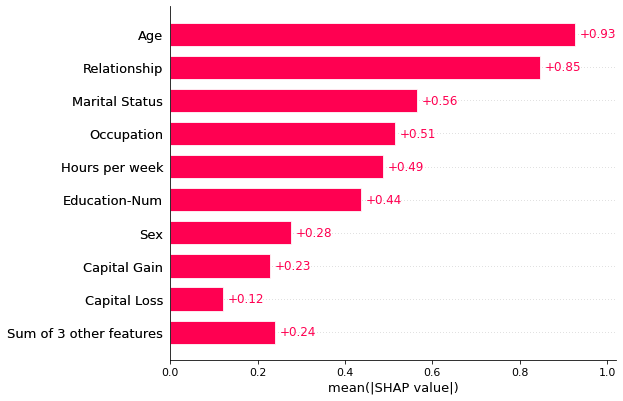

In [6]:
shap.plots.bar(sv_true)  # correct

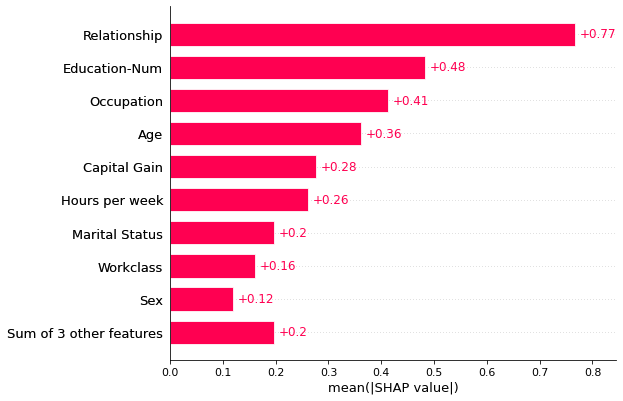

In [7]:
shap.plots.bar(sv_false)  # incorrect

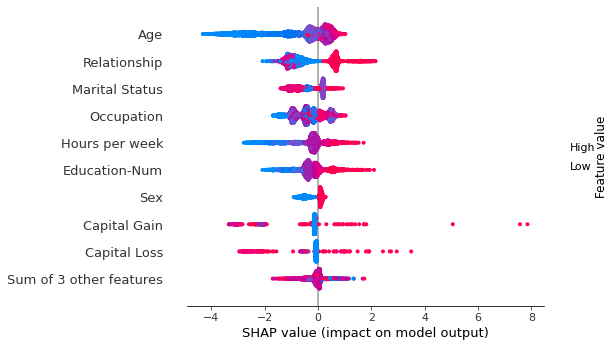

In [18]:
shap.plots.beeswarm(sv_true, order=sv_true.abs.mean(0))

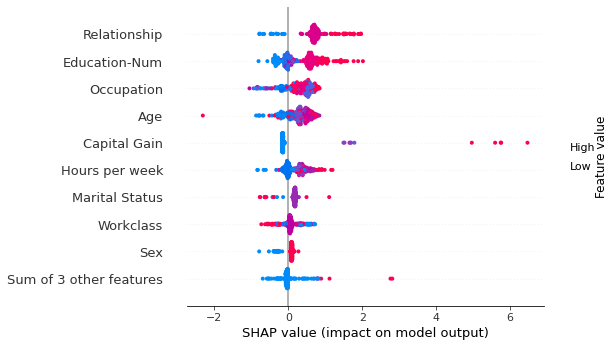

In [19]:
shap.plots.beeswarm(sv_false, order=sv_false.abs.mean(0))

Interaction comparing

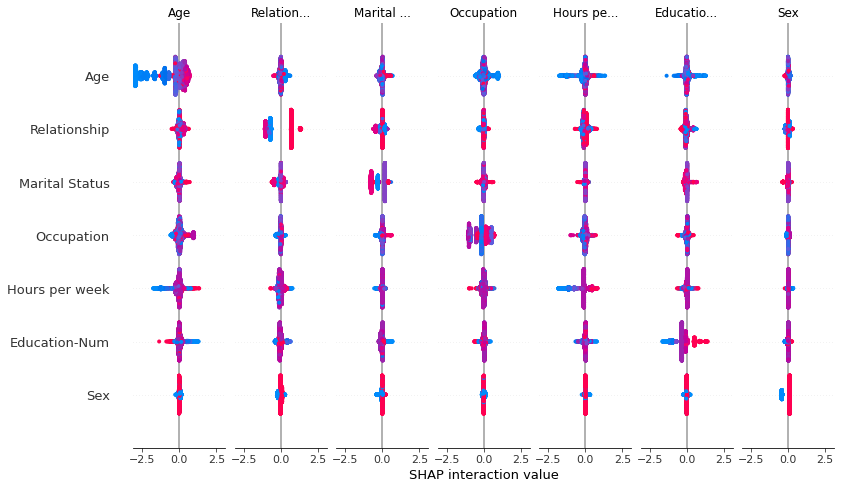

In [24]:
shap.summary_plot(siv_true, data_true)

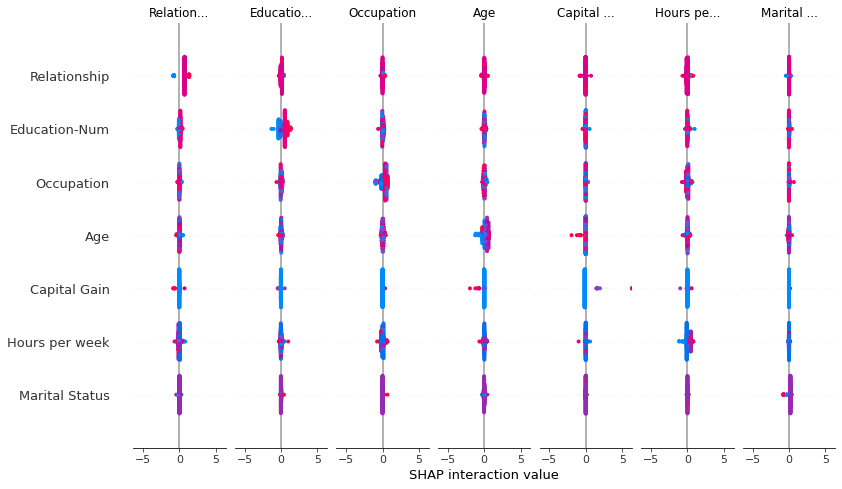

In [36]:
shap.summary_plot(siv_false, data_false)

https://towardsdatascience.com/analysing-interactions-with-shap-8c4a2bc11c2a

In [164]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score

def batch_tril_indexing(A: np.ndarray, k: int, cols: pd.Index=None, include_main_effect: bool=False):
    rt_pd = False if cols is None else True
    # lower_triangle
    r, c = np.tril_indices(k, -1)
    if include_main_effect:
        r_diag, c_diag = np.diag_indices(k)
        mat = np.concatenate((A[:, r_diag, c_diag], A[:, r, c]), axis=1)
    else:
        mat = A[:, r, c]
    
    if rt_pd:
        cs = list(map(lambda x: f'{x[0]}+{x[1]}', zip(*(cols[r], cols[c]))))
        if include_main_effect:
            cs = list(cols) + cs
        return pd.DataFrame(mat, columns=cs)
    else:
        return mat

feature_names = X_test.columns
include_main_effect = True
siv_true_dense = batch_tril_indexing(siv_true, k=len(feature_names), cols=feature_names, include_main_effect=include_main_effect)
siv_false_dense = batch_tril_indexing(siv_false, k=len(feature_names), cols=feature_names, include_main_effect=include_main_effect)

data_true_norm = MinMaxScaler().fit_transform(data_true)
data_false_norm = MinMaxScaler().fit_transform(data_false)
reducer_true = PCA(n_components=7)
reducer_false = PCA(n_components=7)
data_true_reduced = reducer_true.fit_transform(data_true_norm)
data_false_reduced = reducer_false.fit_transform(data_false_norm)

print(f'explained : {reducer_true.explained_variance_ratio_.sum():.4f} / {reducer_false.explained_variance_ratio_.round(4).sum():.4f}')

clusters_true = defaultdict(dict)
for k in range(3, 10):
    kmeans_model = KMeans(k)
    kmeans_model.fit(data_true_reduced)
    clusters_true[k]['model'] = kmeans_model
    clusters_true[k]['score'] = silhouette_score(data_true_reduced, kmeans_model.labels_, metric='euclidean')

print(f"{[round(clusters_true[k]['score'], 4) for k in range(3, 10)]}")

clusters_false = defaultdict(dict)
for k in range(3, 10):
    kmeans_model = KMeans(k)
    kmeans_model.fit(data_false_reduced)
    clusters_false[k]['model'] = kmeans_model
    clusters_false[k]['score'] = silhouette_score(data_false_reduced, kmeans_model.labels_, metric='euclidean')

print(f"{[round(clusters_false[k]['score'], 4) for k in range(3, 10)]}")

explained : 0.9007 / 0.8755
[0.3166, 0.2957, 0.3086, 0.2732, 0.2736, 0.2856, 0.2987]
[0.3303, 0.3696, 0.3897, 0.4057, 0.4016, 0.3996, 0.314]


In [166]:
kmeans_model = clusters_true[3]['model']
labels = kmeans_model.labels_

In [175]:
rnd_idx = np.random.choice(np.arange(len(labels))[labels == 0], 2)

In [183]:
sv_true.values[rnd_idx, :]

array([[ 0.2848356 , -0.08530402, -0.23552065,  0.18482238, -0.09710612,
         0.6538584 ,  0.00339291,  0.08293758, -0.15009658, -0.08012978,
        -0.12188271,  0.01526664],
       [-0.79878026,  0.0102602 ,  0.9239714 , -1.0094588 ,  0.4254936 ,
        -1.2238935 ,  0.03613773,  0.11608359, -0.12256858, -0.05887189,
        -0.05672618,  0.03073811]], dtype=float32)

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


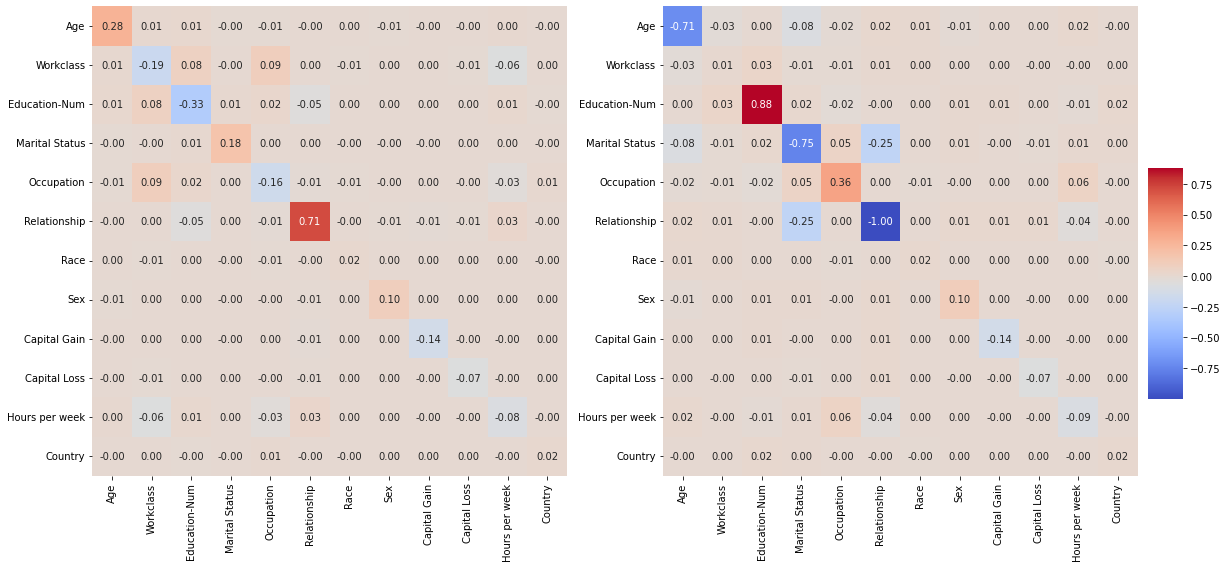

In [205]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
vmin = siv_true[rnd_idx].min()
vmax = siv_true[rnd_idx].max()
cbar_ax = fig.add_axes([1.0, .3, .03, .4])

for i in range(2):
    sns.heatmap(
        data=pd.DataFrame(siv_true[rnd_idx][i], index=feature_names, columns=feature_names), 
        cmap='coolwarm', vmin=vmin, vmax=vmax, annot=True, fmt='.2f', ax=axes[i], 
        cbar=True if i == 0 else False, cbar_ax=cbar_ax if i == 0 else None
    )
plt.tight_layout()
plt.show()

In [207]:
data_true.iloc[rnd_idx]

Age  Workclass  Education-Num  Marital Status  Occupation  \
13670  43.0          7            9.0               2           3   
26215  28.0          4           14.0               4          10   

       Relationship  Race  Sex  Capital Gain  Capital Loss  Hours per week  \
13670             4     4    1           0.0           0.0            40.0   
26215             3     4    1           0.0           0.0            40.0   

       Country  
13670       39  
26215       39

In [74]:
idx = 0
idx_data = X_display.loc[data_true.iloc[idx].name]
idx_data

Age                           39.0
Workclass                  Private
Education-Num                 10.0
Marital Status            Divorced
Occupation         Exec-managerial
Relationship             Unmarried
Race                         White
Sex                         Female
Capital Gain                   0.0
Capital Loss                 625.0
Hours per week                40.0
Country              United-States
Name: 18329, dtype: object

In [75]:
shap.force_plot(explainer.expected_value, sv_true[idx].values, idx_data)

In [79]:
pd.Series(sv_true[idx].values, index=X_display.columns, name='shap_values')

Age               0.060528
Workclass         0.054576
Education-Num    -0.168433
Marital Status   -0.551984
Occupation        0.500479
Relationship     -1.080688
Race              0.010100
Sex              -0.491730
Capital Gain     -0.125933
Capital Loss     -0.418798
Hours per week   -0.202995
Country          -0.001085
Name: shap_values, dtype: float32

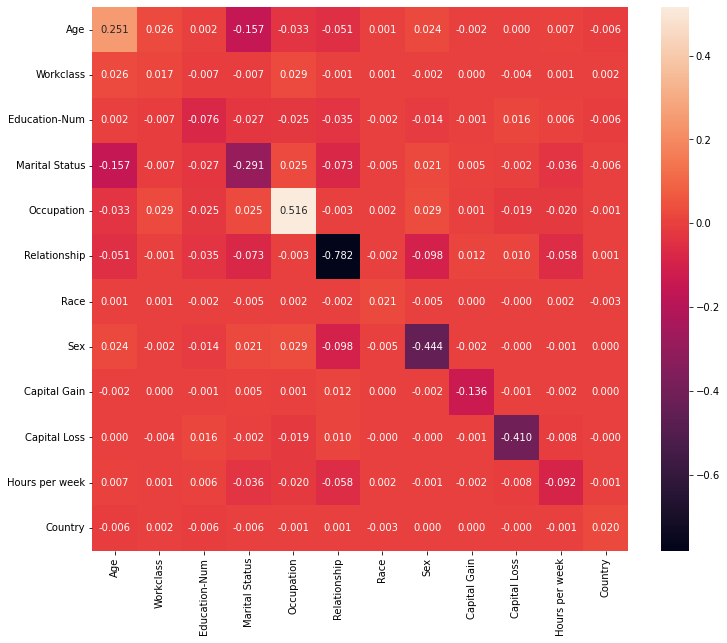

In [73]:
i = 0
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.heatmap(pd.DataFrame(siv_true[i], index=X.columns, columns=X.columns), annot=True, fmt='.3f', ax=ax)
plt.show()

## Label == 1

In [42]:
def batch_tril_indexing(A, dim=1, cols=None):
    rt_pd = False if cols is None else True
    k = A.shape[dim]
    r, c = np.tril_indices(k, -1)
    if rt_pd:
        cs = list(zip(*(cols[r], cols[c])))
        return pd.DataFrame(A[:, r, c], columns=cs)
    else:
        return A[:, r, c]

In [44]:
siv_true_dense = batch_tril_indexing(siv_true, dim=1, cols=X_test.columns)
siv_true_dense

(Workclass, Age)  (Education-Num, Age)  (Education-Num, Workclass)  \
0             0.025938              0.002009                   -0.007029   
1            -0.038652              0.020911                   -0.007085   
2             0.327300              0.405183                    0.330101   
3            -0.111667             -0.006674                   -0.047047   
4            -0.033776             -0.028265                   -0.054430   
...                ...                   ...                         ...   
4658         -0.023527             -0.007523                   -0.007433   
4659          0.086452              0.030259                    0.005841   
4660         -0.363184             -0.033498                    0.072293   
4661         -0.069788              0.610605                   -0.085657   
4662          0.011663             -0.004887                    0.002664   

      (Marital Status, Age)  (Marital Status, Workclass)  \
0                 -0.157218                    -0.007111   
1                  0.001821                     0.002129   
2                 -0.014333                     0.015391   
3                 -0.013631                    -0.008854   
4                  0.093100                    -0.011333   
...                     ...                          ...   
4658              -0.013651                    -0.007097   
4659               0.052435                     0.000026   
4660              -0.022807                    -0.031756   
4661               0.043236                    -0.011656   
4662              -0.006668                     0.001521   

      (Marital Status, Education-Num)  (Occupation, Age)  \
0                           -0.026619          -0.033413   
1                            0.003630           0.468868   
2                            0.001086          -0.041491   
3                           -0.004565          -0.065434   
4                            0.032582          -0.076907   
...                               ...                ...   
4658                        -0.019402          -0.156947   
4659                         0.009811          -0.239693   
4660                        -0.020119          -0.249718   
4661                         0.288547           0.045090   
4662                        -0.000668           0.016430   

      (Occupation, Workclass)  (Occupation, Education-Num)  \
0                    0.028619                    -0.025211   
1                   -0.006445                     0.005128   
2                   -0.031653                    -0.008460   
3                    0.062508                     0.053198   
4                   -0.012512                    -0.008232   
...                       ...                          ...   
4658                -0.005977                    -0.004788   
4659                 0.070256                    -0.012497   
4660                -0.018094                    -0.008711   
4661                -0.001929                     0.068129   
4662                 0.007696                     0.018588   

      (Occupation, Marital Status)  ...  (Country, Workclass)  \
0                         0.025257  ...              0.001598   
1                        -0.003581  ...              0.001794   
2                        -0.017522  ...              0.001315   
3                        -0.005327  ...             -0.000520   
4                        -0.028281  ...             -0.009609   
...                            ...  ...                   ...   
4658                     -0.057850  ...              0.001663   
4659                     -0.007245  ...             -0.079842   
4660                     -0.053203  ...             -0.009713   
4661                     -0.011853  ...             -0.018759   
4662                      0.001589  ...              0.001842   

      (Country, Education-Num)  (Country, Marital Status)  \
0                    -0.006362                  -0.005914   
1  

In [47]:
siv_true_dense.describe().T.sort_values('mean')

count      mean       std       min  \
(Hours per week, Age)           4663.0 -0.052560  0.183638 -0.890346   
(Relationship, Marital Status)  4663.0 -0.044086  0.112743 -0.312127   
(Sex, Relationship)             4663.0 -0.019221  0.056761 -0.123172   
(Hours per week, Relationship)  4663.0 -0.017910  0.079454 -0.353277   
(Workclass, Age)                4663.0 -0.017668  0.088109 -0.435117   
...                                ...       ...       ...       ...   
(Occupation, Education-Num)     4663.0  0.006511  0.042471 -0.319091   
(Hours per week, Sex)           4663.0  0.006610  0.033101 -0.120756   
(Occupation, Age)               4663.0  0.013798  0.127353 -0.303132   
(Education-Num, Age)            4663.0  0.017858  0.096096 -0.681982   
(Relationship, Age)             4663.0  0.025472  0.068285 -0.262531   

                                     25%       50%       75%       max  
(Hours per week, Age)          -0.070341 -0.005567  0.020646  0.672473  
(Relationship, Marital Status) -0.093393  0.002439  0.017038  0.168097  
(Sex, Relationship)            -0.083950 -0.010032  0.016222  0.145755  
(Hours per week, Relationship) -0.066409 -0.045109  0.031369  0.392371  
(Workclass, Age)               -0.044936 -0.023100  0.018205  0.515162  
...                                  ...       ...       ...       ...  
(Occupation, Education-Num)    -0.010399  0.012184  0.024017  0.231291  
(Hours per week, Sex)          -0.004044  0.000747  0.003092  0.170621  
(Occupation, Age)              -0.043143 -0.001114  0.040923  0.498648  
(Education-Num, Age)           -0.019282  0.002378  0.035891  0.648192  
(Relationship, Age)            -0.014080  0.009426  0.052011  0.317757  

[66 rows x 8 columns]

# Page Rank

https://lovit.github.io/machine%20learning/2018/04/17/pagerank_implementation_dict_vs_numpy/

$$PR(u) = c \times \sum_{v \in B_u} \frac{PR(v)}{N_v} + (1 - c) \times \frac{1}{N}$$

# Gradient Boost training

## regression

https://youtu.be/3CC4N4z3GJc

In [54]:
import pandas as pd
from collections import defaultdict
from sklearn.tree import DecisionTreeRegressor, plot_tree, DecisionTreeClassifier
import matplotlib.pyplot as plt
import shap

shap.initjs()

def draw_tree(tree):
    _, ax = plt.subplots(1, 1, figsize=(12, 6))
    annots = plot_tree(tree, filled=True, ax=ax)
    plt.show()

def prediction(trees, df_X, lr):
    pred = np.ones(shape=(df_X.shape[0],)) * trees['base']
    tree_idx = sorted([k for k in trees.keys() if isinstance(k, int)])
    for ti in tree_idx:
        pred += lr * trees[ti].predict(df_X)
    return pred

def get_explanation(model, X):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(X)
    shap_interaction_values = explainer.shap_interaction_values(X)
    return explainer, shap_values, shap_interaction_values

df_X = pd.DataFrame({
    'height': [1.6, 1.6, 1.5, 1.8, 1.5, 1.4],
    'favorite_color': ['B', 'G', 'B', 'R', 'G', 'B'],
    'gender': ['m', 'f', 'f', 'm', 'm', 'f']
})
df_y = pd.Series([88, 76, 56, 73, 77, 57], dtype=np.float32, name='weight')

encode_dict = {
    'favorite_color': {'B': 0, 'G': 1, 'R': 2},
    'gender': {'m': 0, 'f': 1}
}
X = df_X.copy()
X['favorite_color'] = X['favorite_color'].map(encode_dict['favorite_color'])
X['gender'] = X['gender'].map(encode_dict['gender'])
y = df_y.copy()

learning_rate = 0.1

trees = defaultdict()
residuals = defaultdict()
seed = 8

pd.concat([X, y], axis=1)

height  favorite_color  gender  weight
0     1.6               0       0    88.0
1     1.6               1       1    76.0
2     1.5               0       1    56.0
3     1.8               2       0    73.0
4     1.5               1       0    77.0
5     1.4               0       1    57.0

--- Round 1 ---
Base Value: 71.167
Residuals: [ 16.833   4.833 -15.167   1.833   5.833 -14.167]


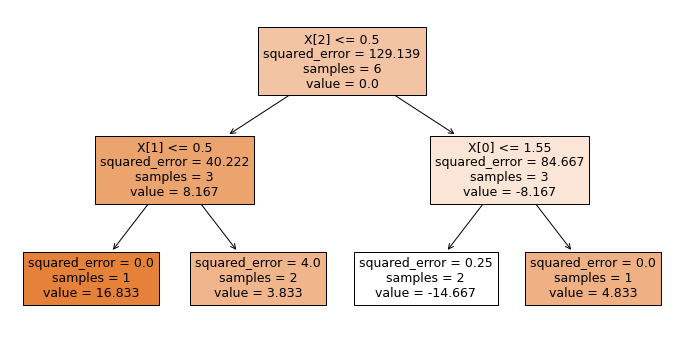

In [41]:
r = 0
print(f'--- Round {r+1} ---')
# predicting weights
y_base = y.mean()
print(f'Base Value: {y_base:.3f}')
trees['base'] = y_base

y_pred = y_base
# pseudo residuals
residual = y - y_pred
print(f'Residuals: {residual.values.round(3)}')

# build a tree with residuals
tree = DecisionTreeRegressor(criterion='squared_error', max_depth=2, max_leaf_nodes=4, random_state=seed)
tree.fit(X, residual)

draw_tree(tree)
# node 1: 16.833 | node 2: (1.833+5.833)/2 | node 3: (-15.167 + -14.167)/2 | node 4: 4.833
# save the tree
trees[r] = tree
# label the residuals
residuals[r] = tree.tree_.value.squeeze()[tree.tree_.feature < 0][np.array((2, 3, 0, 1))]

--- Round 2 ---
New Prediction: [72.85 71.65 69.7  71.55 71.55 69.7 ]
True: [88. 76. 56. 73. 77. 57.]
Residuals: [ 15.15   4.35 -13.7    1.45   5.45 -12.7 ]


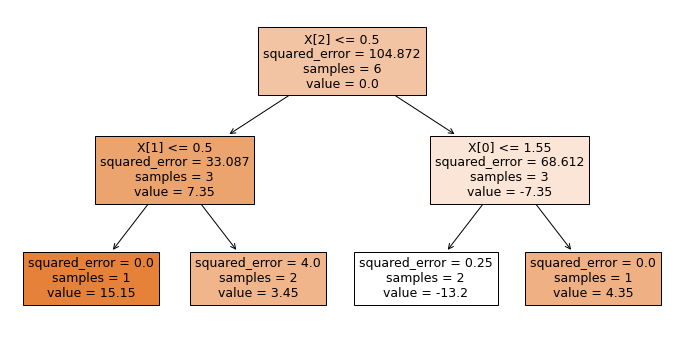

In [42]:
r = 1
print(f'--- Round {r+1} ---')
y_pred = prediction(trees, X, lr=learning_rate)
print(f'New Prediction: {y_pred.round(3)}')
print(f'True: {y.values}')
# pseudo residuals
# - [ \dfrac{\partial L(y, F(X)) / \parcial F(X)} ]_{F(x) = F_{m-1}(x)}
residual = y - y_pred
print(f'Residuals: {residual.values.round(3)}')

# build a tree with residuals
tree = DecisionTreeRegressor(criterion='squared_error', max_depth=2, max_leaf_nodes=4, random_state=seed)
tree.fit(X, residual)

draw_tree(tree)
# save the tree
trees[r] = tree
# label the residuals
residuals[r] = tree.tree_.value.squeeze()[tree.tree_.feature < 0][np.array((2, 3, 0, 1))]

--- Round 3 ---
New Prediction: [74.365 72.085 68.38  71.895 71.895 68.38 ]
True: [88. 76. 56. 73. 77. 57.]
Residuals: [ 13.635   3.915 -12.38    1.105   5.105 -11.38 ]


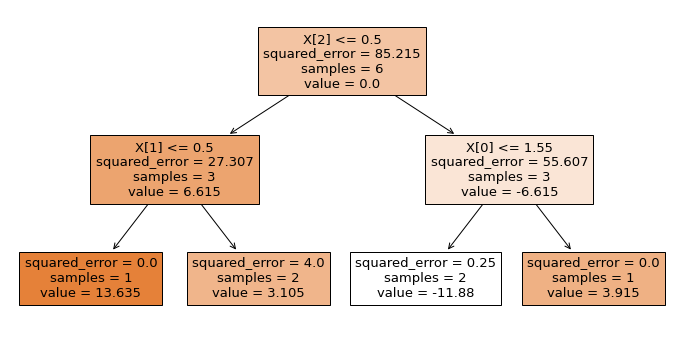

In [43]:
r = 2
print(f'--- Round {r+1} ---')
y_pred = prediction(trees, X, lr=learning_rate)
print(f'New Prediction: {y_pred.round(3)}')
print(f'True: {y.values}')
# pseudo residuals
residual = y - y_pred
print(f'Residuals: {residual.values.round(3)}')

# build a tree with residuals
tree = DecisionTreeRegressor(criterion='squared_error', max_depth=2, max_leaf_nodes=4, random_state=seed)
tree.fit(X, residual)

draw_tree(tree)
# save the tree
trees[r] = tree
# label the residuals
residuals[r] = tree.tree_.value.squeeze()[tree.tree_.feature < 0][np.array((2, 3, 0, 1))]

In [47]:
xgb_full = xgboost.DMatrix(X, label=y.values)

params = {
    'eta': 0.1,
    'max_depth': 2,
    'max_leaves': 4,
    'objective': 'reg:squarederror',
    'seed': seed
}
model = xgboost.train(params, xgb_full, 300, evals=[(xgb_full, "test")], verbose_eval=100)

[0]	test-rmse:65.60129
[100]	test-rmse:0.47935
[200]	test-rmse:0.03679
[299]	test-rmse:0.00313


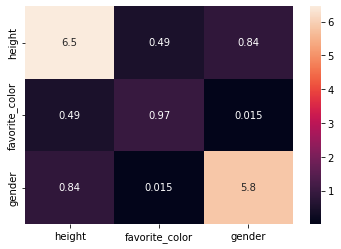

In [45]:
exp, sv, siv = get_explanation(model, X)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.heatmap(pd.DataFrame(np.abs(siv).mean(0), index=X.columns, columns=X.columns), annot=True, ax=ax)
plt.show()

## Classification

https://youtu.be/jxuNLH5dXCs

In [62]:
df_X = pd.DataFrame({
    'like_popcorn': [True, True, False, True, False, False],
    'age': [12, 87, 44, 19, 32, 14],
    'favorite_color': ['B', 'G', 'B', 'R', 'G', 'B']
})
df_y = pd.Series([True, True, False, False, True, True], dtype=np.uint8, name='love_troll_2')

encode_dict = {
    'favorite_color': {'B': 0, 'G': 1, 'R': 2},
}
X = df_X.copy()
X['favorite_color'] = X['favorite_color'].map(encode_dict['favorite_color'])
X['like_popcorn'] = X['like_popcorn'].astype(np.uint8)
y = df_y.copy()

learning_rate = 0.1

trees = defaultdict()
residuals = defaultdict()
seed = 8

pd.concat([X, y], axis=1)

like_popcorn  age  favorite_color  love_troll_2
0             1   12               0             1
1             1   87               1             1
2             0   44               0             0
3             1   19               2             0
4             0   32               1             1
5             0   14               0             1

In [64]:
def log_odds(y):
    u, cnts = np.unique(y, return_counts=True)
    u_dict = dict(zip(u, cnts))
    print(u_dict)
    return np.log(u_dict[1]/u_dict[0])

def kernel(r, y_pred):
    

--- Round 1 ---
{0: 2, 1: 4}
Base Value: 0.693
Residuals: [ 0.307  0.307 -0.693 -0.693  0.307  0.307]


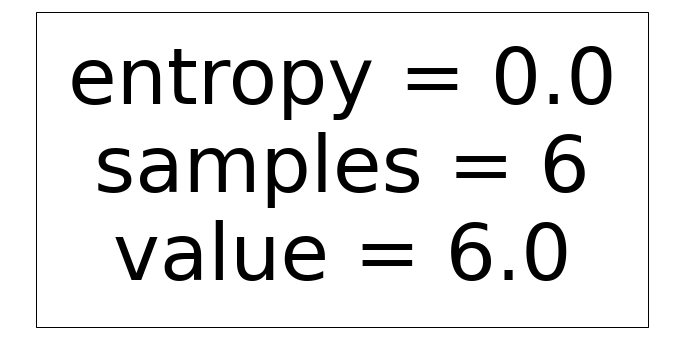

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [66]:
r = 0
print(f'--- Round {r+1} ---')
# predicting weights
y_base = log_odds(y)
print(f'Base Value: {y_base:.3f}')
trees['base'] = y_base

y_pred = y_base
# pseudo residuals
residual = y - y_pred
print(f'Residuals: {residual.values.round(3)}')

# build a tree with residuals
tree = DecisionTreeClassifier(criterion='entropy', max_depth=2, max_leaf_nodes=4, random_state=seed)
tree.fit(X, (residual > 0.5).astype(np.uint8))

draw_tree(tree)
# node 1: 16.833 | node 2: (1.833+5.833)/2 | node 3: (-15.167 + -14.167)/2 | node 4: 4.833
# save the tree
trees[r] = tree
# label the residuals
residuals[r] = tree.tree_.value.squeeze()[tree.tree_.feature < 0][np.array((2, 3, 0, 1))]